# Sorter by Russkaya Krasavica

## Установка библиотек и импорты

In [82]:
import torch
import json

from dataclasses import dataclass, field
from torch.utils.data import Dataset

## Датасет

In [83]:
from typing import List

@dataclass
class Step:
    action: str = ""
    text: str = ""
    arguments: List[str] = field(default_factory=list)

@dataclass
class SorterTask():
    action: str = ""
    text: str = ""
    goal: str = ""
    task_type: int = -1
    plan_id: int = -1
    image: str = ""
    steps: List[Step] = field(default_factory=list)
    arguments: List[str] = field(default_factory=list)

    def to_list(self):
        return [[step.action, [arg for arg in step.arguments]] for step in self.steps]

class SorterDataset(Dataset):
    def __init__(self, path_to_csv: str = ""):
        with open(path_to_csv, 'r') as f:
            self._data = json.load(f)
        self._size = len(self._data)

    def __len__(self):
        return self._size

    def __getitem__(self, idx) -> SorterTask:
        entry = self._data[idx]
        steps = []
        return SorterTask(goal=entry['goal_eng'],
                        steps=steps,
                        task_type=entry['task_type'],
                        plan_id=entry["plan_id"], image=entry['image'])

## Генерация плана

In [84]:
class FullPlanGeneration():
    def __init__(self, model):
        self._model = model

    def predict(self, gt_task: SorterTask) -> SorterTask:
        steps = self._model.generate(gt_task)
        gt_task.steps = steps
        return gt_task

In [85]:
path_to_csv = "/content/test_dataset.json"
dataset = SorterDataset(path_to_csv=path_to_csv)
print(dataset[0])

SorterTask(action='', text='', goal='Put the gray cat in an orange container.', task_type=0, plan_id=0, image='2176356811276008251_0.png', steps=[], arguments=[])


In [108]:
from contextlib import suppress
import json
from typing import Any

import spacy
from spacy.tokens.token import Token

class NLPModel:
    def __init__(self):
        self.model = spacy.load('en_core_web_sm')

    # Рекурсивная функция получения всех дочерних токенов
    def insert_all_children(self, token, result: list, first_it: bool = False) -> list[None] | None:
        if not first_it and token.pos_ != 'DET':
            result.insert(0, token.text)
        if list(token.children):
            return [self.insert_all_children(child, result) for child in reversed(list(token.children))]


    def get_full_prep(self, prep: Token) -> str:
        temp = prep
        full_prep = prep.text
        while hasattr(temp, 'head') and temp.head.pos_ != "VERB":
            full_prep = temp.head.text + ' ' + full_prep
            temp = temp.head
        return full_prep

    def find_nouns_and_preps(self, tokens: list[Token], text: str) -> tuple[dict[str, str], list[str]]:
        preps = {} # словарь предлогов + связанных с ними словосочетаний
        nouns = [] # список всех словосочетаний в предложении

        existing_nouns = []
        # Собираем имена существительные и имена собственные
        for noun in sorted(filter(lambda token: token.pos_ in ('NOUN', 'PROPN'), tokens),
                        key=lambda x: -len(list(x.children))):
            subj = [noun.text]
            self.insert_all_children(noun, subj, first_it=True)

            # если имя сущ. уже было добавлено, как зависимость от другого, то оно существует
            if not any(set(ex_subj) | set(subj) == set(ex_subj) for ex_subj in existing_nouns):
                nouns.append(subj)
            existing_nouns.append(subj)

        # Собираем предлоги и их зависимости
        for prep in filter(lambda token: token.pos_ == "ADP", tokens):
            deps = []
            self.insert_all_children(prep, deps, first_it=True)

            if prep.dep_ == 'prt':
                continue

            prep = self.get_full_prep(prep)
            preps[prep] = ' '.join(deps)

        # сортировка по порядку слов в предложении
        nouns = sorted(nouns, key=lambda noun: text.index(noun[0]))
        return preps, [' '.join(noun) for noun in nouns]


    # Оставляем только существительные с предлогами и прилагательными, которые к ней относятся
    def generate(self, string: str) -> list[str | Any]:
        tokenized = self.model(string)
        prepositions, nouns = self.find_nouns_and_preps(tokenized, string)

        # содержит три главных словосочетания, которые будут ипользоваться в модели компьютерного зрения
        result = ['', '', '']

        nouns = nouns + ['' for _ in range(3 - len(nouns))]
        for preposition, noun in prepositions.items():
            if preposition.lower() in ('from', 'off'):
                result[1] = noun
            else:
                result[2] = noun
            # Ignore possible ValueError
            with suppress(ValueError):
                nouns.remove(noun)

        result[0] = nouns[0]
        return result

In [87]:
# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# class NLPModel:
#   def generate(self, task):
#     tokenized = nltk.word_tokenize(task)
#     nouns = ["", "", ""]

#     result = ""

#     identify = 0
#     for (word, pos) in nltk.pos_tag(tokenized):
#         if pos in ["IN", "TO"] and word in ["from", "off"]:
#             nouns[identify] = result[:-1]
#             result = ""
#             identify = 1
#         elif pos in ["IN", "TO"]:
#             nouns[identify] = result[:-1]
#             result = ""
#             identify = 2
#         result = result + word + ' ' if pos in ['NN', 'JJ'] else result
#     nouns[identify] = result[:-1]
#     return nouns


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [89]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
import os
HOME = os.getcwd()
print(HOME)
%cd ~
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd ~/GroundingDINO
!pip install -q -e .
import os
CONFIG_PATH = "~/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py"
%cd
!mkdir ~/weights
%cd ~/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha2/groundingdino_swinb_cogcoor.pth

/root
/root
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/root/GroundingDINO
  Preparing metadata (setup.py) ... done
/root
mkdir: cannot create directory ‘/root/weights’: File exists
/root/weights


In [90]:
import os

WEIGHTS_NAME = "groundingdino_swinb_cogcoor.pth"
WEIGHTS_PATH = '/root/weights/'+WEIGHTS_NAME
#print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

In [91]:
%cd ~/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

dino_model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/root/GroundingDINO
final text_encoder_type: bert-base-uncased


KeyboardInterrupt: ignored

In [92]:
import supervision as sv
from groundingdino.util import box_ops

BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.1
ROBOT_NAME = "robotic manipulator"

def get_boxes(prompt, image_path):
  image_source, image = load_image(image_path)
  boxes, logits, phrases = predict(
      model=dino_model,
      image=image,
      caption=prompt,
      box_threshold=BOX_TRESHOLD,
      text_threshold=TEXT_TRESHOLD
  )
  return boxes, logits, phrases

def get_full_boxes(what, from_obj, where, img):
  result = [[] for _ in range(3)]
  for obj in [ROBOT_NAME, what, from_obj, where]:
    data = get_boxes(obj, img)
    if len(data[0]) == 0:
      data = [[[0, 0, 0, 0]], [0], [obj]]
    best_i = max(range(len(data[0])), key=lambda i: data[1][i])
    # if obj == ROBOT_NAME:
    #   data[0][0][2] /= 3
    #   data[0][0][3] /= 2
    #   data[0][0][0] -= data[0][0][2]*0.4
    #   data[0][0][1] -= data[0][0][3]*0.5

    for i in range(3):
      elem = data[i][best_i]
      result[i] += [elem.numpy().tolist() if type(elem) == torch.Tensor else elem]

  if DEBUG:
    img_src, _ = load_image(img)
    annotated_frame = annotate(image_source=img_src, boxes=torch.tensor(result[0]), logits=result[1], phrases=result[2])
    %matplotlib inline
    sv.plot_image(annotated_frame, (16, 16))

  return {result[2][i]: box_ops.box_cxcywh_to_xyxy(torch.tensor(result[0][i])) for i in range(len(result[0]))}

In [93]:
from groundingdino.util import box_ops
from torchvision.ops.boxes import box_area
import torch

# def almost_equals(area1, area2):
#   return abs(area1 - area2) < 0.05

def calculate_overflow(robot, thing):
    robot = torch.tensor([robot.numpy()])
    thing = torch.tensor([thing.numpy()])
    area1 = box_area(robot).item()
    area2 = box_area(thing).item()
    # if area2 > area1: # if object is behind robot
    #   return 0

    # calculating intersection
    lt = torch.max(robot[:, None, :2], thing[:, :2])  # [N,M,2]
    rb = torch.min(robot[:, None, 2:], thing[:, 2:])  # [N,M,2]
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = (wh[:, :, 0] * wh[:, :, 1])[0].item()  # [N,M]

    # # object is robot itself
    # if inter > 0 and almost_equals(area1, area2) and almost_equals(area1, inter):
    #   print('inter', inter)
    #   print('area1', area1)
    #   print('found robot denoted as some object')
    #   return -1

    return inter / (area2 + 1e-6)


NEAR_THRESHOLD = 0.1
def is_near(box1, box2):
  return calculate_overflow(box1, box2) > NEAR_THRESHOLD


In [94]:
from dataclasses import dataclass, field
from typing import List
@dataclass
class Step:
    action: str = ""
    text: str = ""
    arguments: List[str] = field(default_factory=list)

def get_commands(what, from_obj, where, img_path):
  o = get_full_boxes(what, from_obj, where, img_path)
  steps = []
  if not is_near(o[ROBOT_NAME], o[what]):
    steps.append(Step(action='move_to', arguments=[from_obj, what]))
    steps.append(Step(action='pick_up', arguments=[from_obj, what]))
  if where:
    if not is_near(o[where], o[what]):
      steps.append(Step(action='move_to', arguments=[where, what]))
    if where:
      steps.append(Step(action='put', arguments=[where, what]))
  return steps

def filter_empty(commands):
  result = []
  for cmd in commands:
    if cmd.action == 'move_to' and not any(cmd.arguments) or cmd.action in ['pick_up', 'put'] and not cmd.arguments[1]:
      continue
    args = [a if a else 'unspecified' for a in cmd.arguments]
    result.append(Step(action=cmd.action, text=cmd.text, arguments=args))

  # for i in range(len(result)):
  #   if result[i].action == 'move_to' and result[i].arguments[1] == 'unspecified' and len(result) == 1:
  #     print('here')
  #     result[i].arguments = result[i].arguments[::-1]

  return result

In [95]:
class CVModel:
  def generate(self, main_words, img_path):
    print('got main words:', main_words)
    return filter_empty(get_commands(*main_words, img_path))

In [96]:
class PipelineModel:
  def __init__(self, nlp_model, cv_model, img_prefix):
    self.nlp_model = nlp_model
    self.cv_model = cv_model

  def generate(self, task):
    return self.cv_model.generate(self.nlp_model.generate(task.goal), img_prefix + task.image)

In [110]:
img_prefix = '/content/test_images/'
pipeline = PipelineModel(NLPModel(), CVModel(), img_prefix)
gen_method = FullPlanGeneration(pipeline)

In [111]:
results = []

DEBUG = False

for i, task in list(enumerate(dataset)):
    answer = {
        'plan_id': task.plan_id,
        'image': task.image,
        'goal_eng': task.goal,
        'task_type': task.task_type,
      }

    predicted_plan = gen_method.predict(task)
    answer['plan'] = predicted_plan.to_list()

    print(answer)
    results.append(answer)

got main words: ['gray cat', '', 'orange container']


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'plan_id': 0, 'image': '2176356811276008251_0.png', 'goal_eng': 'Put the gray cat in an orange container.', 'task_type': 0, 'plan': [['put', ['orange container', 'gray cat']]]}
got main words: ['toy', '', 'floor']
{'plan_id': 1, 'image': '2176356811276008251_0.png', 'goal_eng': 'Put the toy on the floor.', 'task_type': 0, 'plan': [['move_to', ['unspecified', 'toy']], ['pick_up', ['unspecified', 'toy']], ['move_to', ['floor', 'toy']], ['put', ['floor', 'toy']]]}
got main words: ['garlic', 'table', 'chair']
{'plan_id': 2, 'image': '2556860223905553708_0.png', 'goal_eng': 'Take the garlic from the table and put it on a chair.', 'task_type': 0, 'plan': [['put', ['chair', 'garlic']]]}
got main words: ['apple', 'floor', '']
{'plan_id': 3, 'image': '2556860223905553708_0.png', 'goal_eng': 'Pick up the apple from the floor.', 'task_type': 0, 'plan': [['move_to', ['floor', 'apple']], ['pick_up', ['floor', 'apple']]]}
got main words: ['kitten', '', 'table']
{'plan_id': 4, 'image': '265767182640

In [103]:
with open('/content/results.json', 'w') as f:
    json.dump(results, f, indent=4)

In [100]:
from pprint import pprint
def calculate_metrics(path_to_test: str,
                      path_to_results: str) -> float:
    test_records = {}

    with open(path_to_test, 'r') as f:
        test_file = json.load(f)
        for element in test_file:
            test_records[element['plan_id']] = element['plan']

    correct = {}


    with open(path_to_results, 'r') as f:
        results_file = json.load(f)
        for element in results_file:
            if test_records[element['plan_id']] == element['plan']:
                correct[int(element['plan_id'])] = 1
            else:
              correct[int(element['plan_id'])] = 0

    # print(len(test_records))
    return correct, len(results_file)



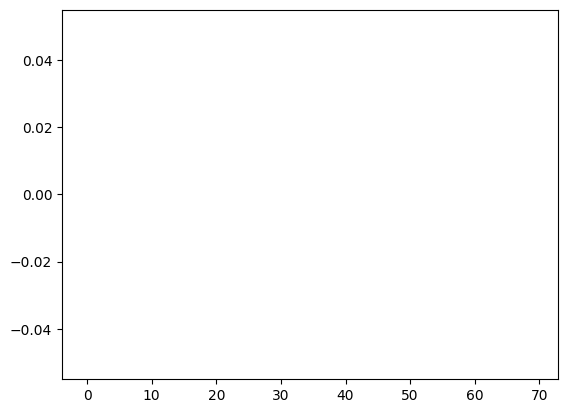

In [101]:
correct, length = calculate_metrics(path_to_test='/content/train_dataset.json',
                  path_to_results='/content/results.json')

from matplotlib import pyplot as plt
x, y = [], []
for plan_id, is_correct in correct.items():
  x.append(plan_id)
  y.append(is_correct)
plt.bar(x, y)
plt.show()

In [102]:
sum(correct.values())/len(correct)

0.0